In [2]:
import chess
import numpy as np
from openTSNE import TSNE
from openTSNE.callbacks import ErrorLogger
from matplotlib import pyplot as plt
from scipy import interpolate

In [5]:
def state_to_vector(state):
    piece_dict = {
        'wr': [1,0,0,0,0,0,0,0,0,0,0,0,0],
        'wn': [0,1,0,0,0,0,0,0,0,0,0,0,0],
        'wb': [0,0,1,0,0,0,0,0,0,0,0,0,0],
        'wk': [0,0,0,1,0,0,0,0,0,0,0,0,0],
        'wq': [0,0,0,0,1,0,0,0,0,0,0,0,0],
        'wp': [0,0,0,0,0,1,0,0,0,0,0,0,0],
        'br': [0,0,0,0,0,0,1,0,0,0,0,0,0],
        'bn': [0,0,0,0,0,0,0,1,0,0,0,0,0],
        'bb': [0,0,0,0,0,0,0,0,1,0,0,0,0],
        'bk': [0,0,0,0,0,0,0,0,0,1,0,0,0],
        'bq': [0,0,0,0,0,0,0,0,0,0,1,0,0],
        'bp': [0,0,0,0,0,0,0,0,0,0,0,1,0],
        '':   [0,0,0,0,0,0,0,0,0,0,0,0,1],
    }    
    state_list = list(state.values())    
    vector = []
    for piece in state_list:
        vector.append(piece_dict[piece])
    return np.array(vector).ravel()

def vector_to_state(vector):
    vec_dict = {
        '1000000000000': "wr",
        '0100000000000': "wn",
        '0010000000000': "wb",
        '0001000000000': "wk",
        '0000100000000': "wq",
        '0000010000000': "wp",
        '0000001000000': "br",
        '0000000100000': "bn",
        '0000000010000': "bb",
        '0000000001000': "bk",
        '0000000000100': "bq",
        '0000000000010': "bp",
        '0000000000001': ""
    }
    
    return vec_dict[vector]

In [6]:
def game_to_vectors(file):
    moves = chess.get_moves_from_pgn(file)
    game = chess.ChessGame()
    vectors = [state_to_vector(game.state)]
    for move in moves:
        game.push(move)
        vectors.append(state_to_vector(game.state))
    return np.stack(vectors)

In [7]:
print("start loading")

start loading


In [8]:
np.random.seed(0)
randgames = ['games/game-{:05d}.pgn'.format(n) for n in np.unique(np.random.randint(40000,size=50))]

In [9]:
notrandgames = ['games/game-{:05d}.pgn'.format(n+1) for n in range(10000)]

In [10]:
notrandgames_checked = []
for id, g in enumerate(notrandgames):
    try:
        game_to_vectors(g)
    except:
        pass
    else:
        notrandgames_checked.append((id,g))

In [3]:
chess.get_moves_from_pgn('alphazero_vs_stockfish_all.pgn')

AttributeError: module 'chess' has no attribute 'get_moves_from_pgn'

In [12]:
firstmoves = [(g[0],chess.get_moves_from_pgn(g[1])[0]) for g in notrandgames_checked]

In [13]:
nf3_indices = []
for idx, fm in firstmoves:
    if fm == 'Nf3':
        nf3_indices.append(idx)

In [14]:
d4_indices = []
for idx, fm in firstmoves:
    if fm == 'd4':
        d4_indices.append(idx)

In [15]:
c4_indices = []
for idx, fm in firstmoves:
    if fm == 'c4':
        c4_indices.append(idx)

In [16]:
e4_indices = []
for idx, fm in firstmoves:
    if fm == 'e4':
        e4_indices.append(idx)

In [17]:
nf3_games = ['games/game-{:05d}.pgn'.format(n+1) for n in np.array(nf3_indices)[:150]]
d4_games = ['games/game-{:05d}.pgn'.format(n+1) for n in np.array(d4_indices)[:150]]
c4_games = ['games/game-{:05d}.pgn'.format(n+1) for n in np.array(c4_indices)[:150]]
e4_games = ['games/game-{:05d}.pgn'.format(n+1) for n in np.array(e4_indices)[:150]]

In [18]:
print(len(e4_games))

0


In [19]:
both_games = np.concatenate([nf3_games, d4_games, c4_games])

In [20]:
game_matrices = [game_to_vectors(g) for g in both_games]


In [21]:
final_data = np.concatenate(game_matrices)

ValueError: need at least one array to concatenate

In [19]:
tsne = TSNE(
    perplexity=200,
    n_jobs=6,
    metric='euclidean',
    random_state=42
)

In [20]:
%time embedding = tsne.fit(np.array(final_data))

c:\users\moritz\appdata\local\programs\python\python37\lib\site-packages\openTSNE\nearest_neighbors.py:184: UserWarning: `pynndescent` has recently changed which distance metrics are supported, and `openTSNE.nearest_neighbors` has not been updated. Please notify the developers of this change.
  "`pynndescent` has recently changed which distance metrics are supported, "
c:\users\moritz\appdata\local\programs\python\python37\lib\site-packages\numba\ir_utils.py:1969: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'forest' of function 'initialise_search'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "..\appdata\local\programs\python\python37\lib\site-packages\pynndescent\pynndescent_.py", line 72:
@numba.njit()
def initialise_search(
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc

Wall time: 3min 37s


In [21]:
embedding_split = np.array_split(embedding, np.add.accumulate([len(l) for l in game_matrices]))[:-1]

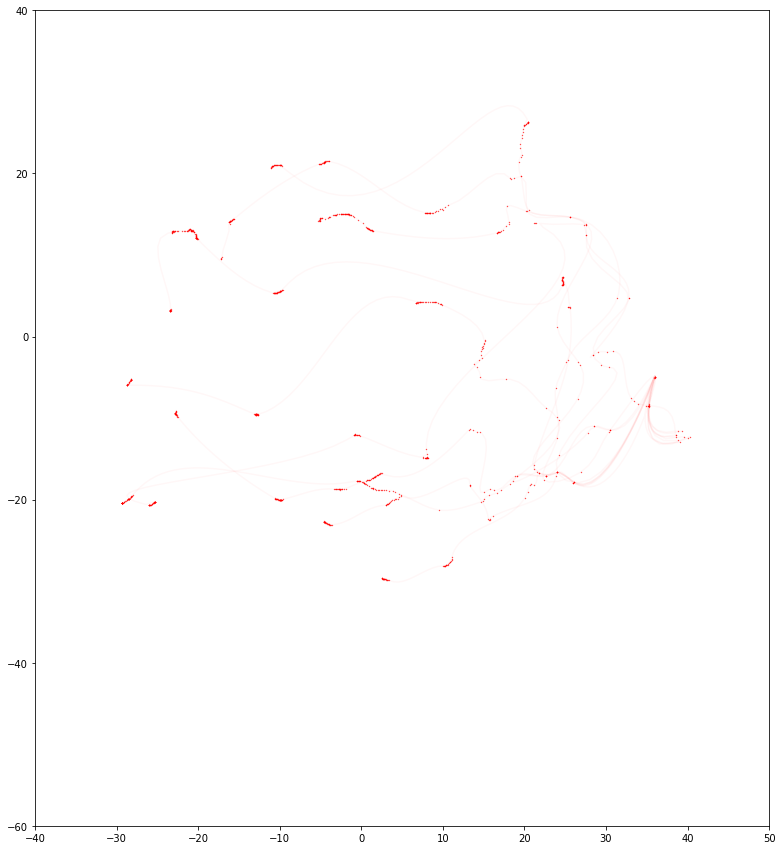

In [22]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111)
ax.set_aspect(1)
for game in embedding_split[:10]:
    tck, u = interpolate.splprep(game.transpose(), s=0)
    unew = np.arange(0, 1.01, 0.01)
    out = interpolate.splev(unew, tck)
    ax.plot(out[0], out[1], '-r', alpha=0.03, color='red')
    ax.scatter(game[:,0], game[:,1], s=0.1, color='red')
#for game in embedding_split[10:800]:
#    tck, u = interpolate.splprep(game.transpose(), s=0)
#    unew = np.arange(0, 1.01, 0.01)
#    out = interpolate.splev(unew, tck)
#    ax.plot(out[0], out[1], '-r', alpha=0.03, color='blue')
#    ax.scatter(game[:,0], game[:,1], s=0.1, color='blue')
plt.xlim((-40,50));
plt.ylim((-60,40));
#for game in embedding_split[100:]:
#    ax.plot(game[:,0], game[:,1], '-r', alpha=0.1, color='blue')


# write header
csv = open("test.csv", "w")
csv.write("x,y,cubeNum,cp,algo,age,a8,b8,c8,d8,e8,f8,g8,h8,a7,b7,c7,d7,e7,f7,g7,h7,a6,b6,c6,d6,e6,f6,g6,h6,a5,b5,c5,d5,e5,f5,g5,h5,a4,b4,c4,d4,e4,f4,g4,h4,a3,b3,c3,d3,e3,f3,g3,h3,a2,b2,c2,d2,e2,f2,g2,h2,a1,b1,c1,d1,e1,f1,g1,h1")
csv.write("\n")
idx = 0

for gameIndex, game in enumerate(embedding_split[:450]):
    pi = 0
    for idx, pos in enumerate(game):
        csv.write(str(pos[0]))
        csv.write(",")
        csv.write(str(pos[1]))
        
        # number of game
        csv.write(",")
        csv.write(str(gameIndex))
        
        # checkpoint
        csv.write(",")
        if idx == 0:
            csv.write("1")
        elif idx == len(game) - 1:
            csv.write("1")
        else:
            csv.write("0")
        
        
        
        # method, in this case the starting move
        csv.write(",")
        if 0 <= gameIndex <= 150:
            csv.write("0")
        elif 100 < gameIndex <= 300:
            csv.write("1")
        else:
            csv.write("2")
        
        # age
        csv.write(",")
        csv.write(str(idx))
        
        for n in range(0, 64):
            csv.write(",")
            str1 = ''.join(str(e) for e in game_matrices[gameIndex][idx][n * 13: (n+1) * 13])
            csv.write(vector_to_state(str1))
            
        csv.write("\n")
    gameIndex += 1
        
csv.close()

In [23]:
import umap

ModuleNotFoundError: No module named 'umap'

In [ ]:
reducer = umap.UMAP()

In [ ]:
umap_embedding = reducer.fit_transform(final_data)

In [ ]:
umap_embedding_split = np.array_split(umap_embedding, np.add.accumulate([len(l) for l in game_matrices]))[:-1]

In [ ]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.set_aspect(1)
for game in umap_embedding_split[:100]:
    ax.plot(game[:,0], game[:,1], '-r', alpha=0.1, color='red')
for game in umap_embedding_split[100:]:
    ax.plot(game[:,0], game[:,1], '-r', alpha=0.1, color='blue')